<a href="https://colab.research.google.com/github/AgaMiko/pixel_character_generator/blob/master/Conditional_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN - Pixel character generation
Author: Agnieszka Mikołajczyk https://github.com/AgaMiko

Notebook based on the pytorch DCGAN tutorial https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
- Added soft labels
- Added Wesserstein loss
- Added dropout to discriminator

Link to colab: https://colab.research.google.com/drive/12L_NAfWV0vnR9-zEPda1DxEE3nmWqV9s?usp=sharing
Link to github: https://github.com/AgaMiko/100-days-of-code

In [0]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import random

In [0]:
!pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 752.0MB 22kB/s 
     |████████████████████████████████| 6.6MB 49.2MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [2]:
# Set random seed for reproducibility
manualSeed = '123'
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  123


In [6]:
from google.colab import files
uploaded = files.upload()
!unzip -q data.zip #uzipping dataset

Saving data.zip to data.zip


In [0]:
dataroot = "."

workers = 2 # Number of workers for dataloader
batch_size = 100 
image_size = 64

channels = 3

latent_size = 40
condition_size = 10
feature_map_size = 64
num_epochs = 200

lr_d = 0.0004
lr_g = 0.0001
beta1 = 0.5
ngpu = 1

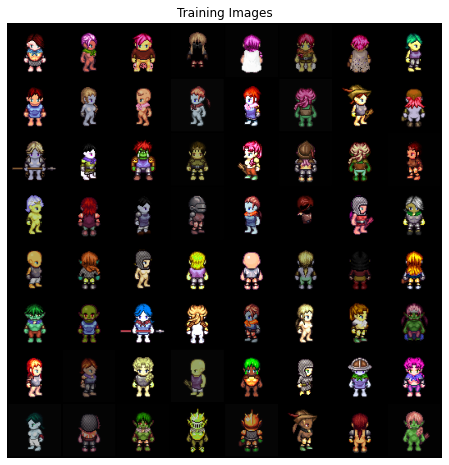

In [8]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot+'/data',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
 
            nn.Conv2d(channels, feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.LeakyReLU(0.2),


            nn.Conv2d(feature_map_size * 2, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),

            nn.Conv2d(feature_map_size * 4, feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.LeakyReLU(0.2),

        )
        self.real_fake = nn.Sequential(
            nn.Conv2d(feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.conv = nn.Sequential(
            nn.Conv2d(feature_map_size * 8, feature_map_size, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.LeakyReLU(0.2),
        )

        self.fc_class = nn.Sequential(
            nn.Linear(feature_map_size,4),
            nn.Sigmoid()
        )

    def forward(self, input, mode ='train'):
      if mode == 'train':
        x = self.main(input)
        return self.real_fake(x)
      if mode == 'pretrain':
        x = self.main(input)
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        x = self.fc_class(x)
        return x

netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
  )
  (real_fake): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  

In [11]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu

        self.condition_embedding = nn.Embedding(4,condition_size)

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size+condition_size, feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_map_size * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(feature_map_size * 8, feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 4),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 4, feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size * 2),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size * 2, feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(),
            nn.ConvTranspose2d( feature_map_size, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input, condition):
      x = self.condition_embedding(condition)
      if len(x.size()) == 1:
        x = x.view(1,x.size(0),1,1)
      else:
        x = x.view(x.size(0),x.size(1),1,1)
      x = torch.cat((input, x), 1)
      return self.main(x)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (condition_embedding): Embedding(4, 10)
  (main): Sequential(
    (0): ConvTranspose2d(50, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [0]:
# Training Loop

# Initialize BCELoss function
criterion_ce = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
criterion_cos = nn.HingeEmbeddingLoss()

def wasserstein_loss(y_true, y_pred):
	return torch.mean(y_true * y_pred)
 
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, latent_size, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)

        # Soft label between 1.1 and 0.9
        label = ((1.1-0.8)*torch.rand((b_size, 1)) + 0.8).to(device)

        output = netD(real_cpu,'train').view(-1)
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        noise = torch.randn(b_size, latent_size, 1, 1, device=device)
        fake = netG(noise,data[1].long().to(device))

        label = (0.1*torch.rand((b_size, 1))).to(device)

        output = netD(fake.detach(),'train').view(-1)
        errD_fake =  criterion(output, label)

        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        output = netD(real_cpu,'pretrain')
        errD += criterion_ce(output, data[1].to(device))*0.5

        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake,'train').view(-1)
        errG = criterion(output, label)

        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
       
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise,data[1].long().to(device)).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

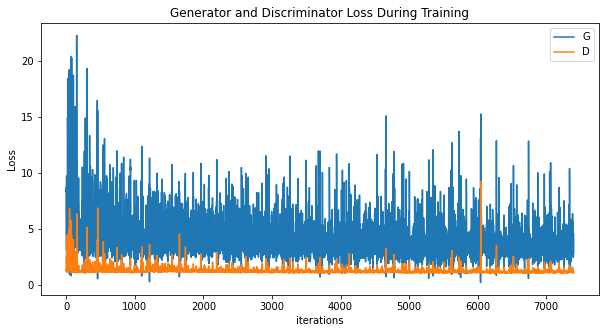

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

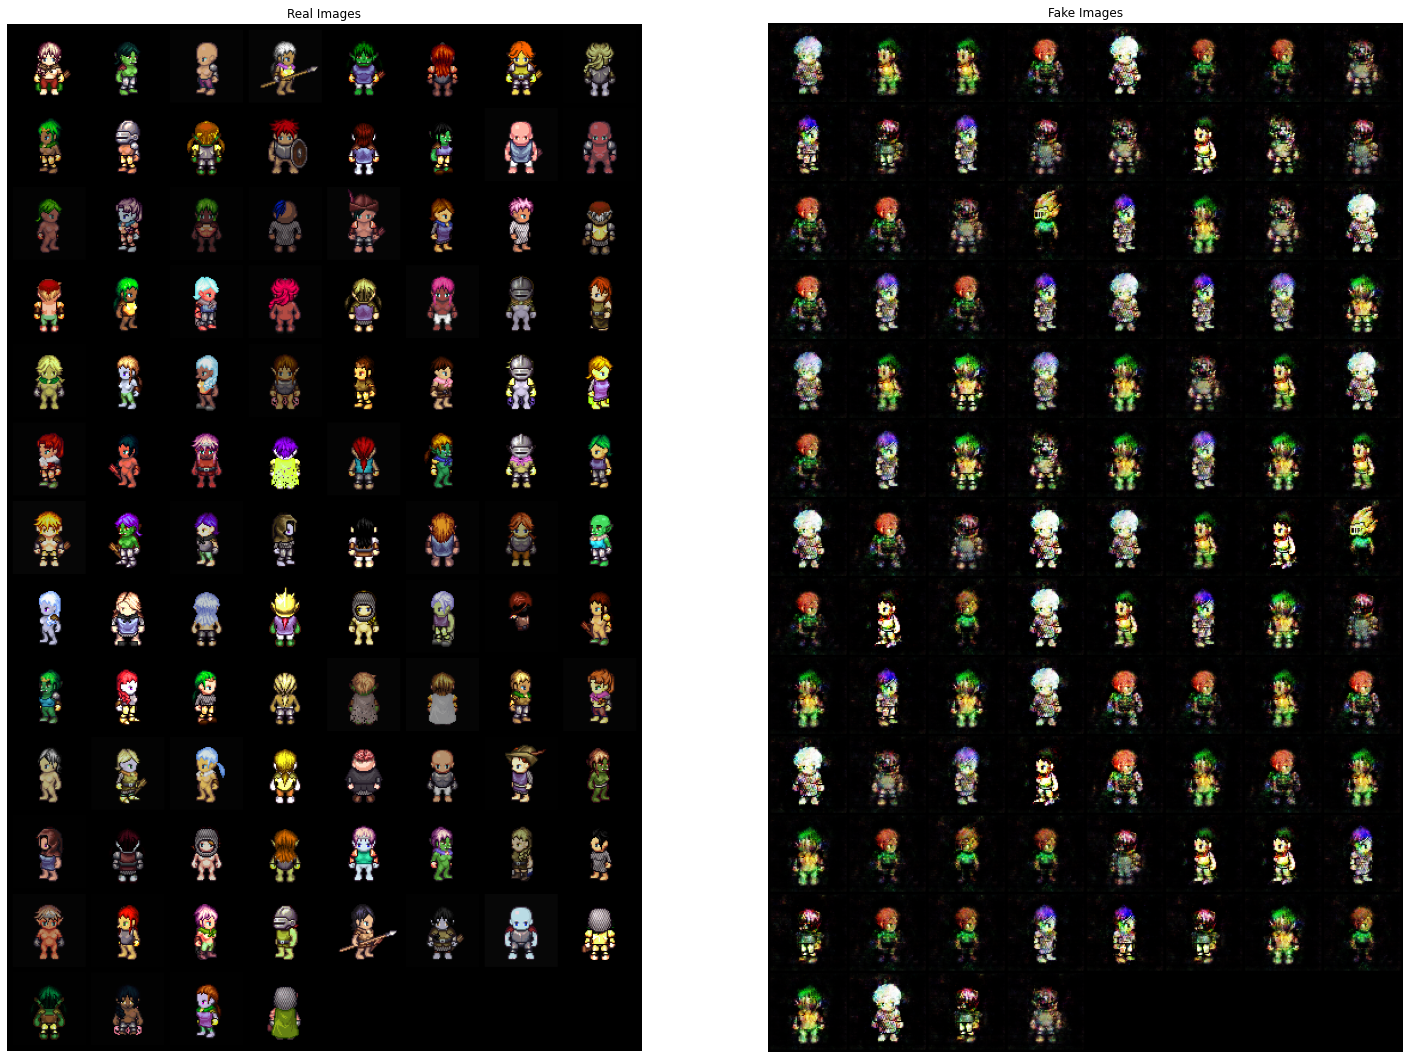

In [14]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

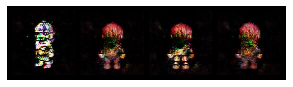

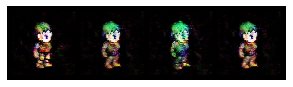

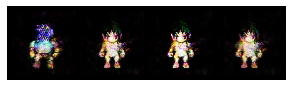

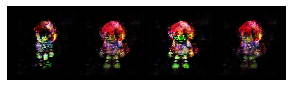

In [15]:
fake=[]
batch=4
with torch.no_grad():
  for k in range(1):
    fixed_noise = torch.randn(batch, latent_size, 1, 1, device=device)
    
    for i in range(4):
      plt.figure(figsize=(5,5))
      #print(fixed_noise.size())
      fake = netG(fixed_noise,torch.tensor([i]*batch).to(device)).detach().cpu()
      #print(fake.size())
      plt.axis("off")
      plt.imshow(np.transpose(vutils.make_grid(fake.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
      

In [0]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())